<a href="https://colab.research.google.com/github/migueasa22/Entrega-2/blob/main/Entrega_2_IA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Importamos las librerias que necesitamos

# comunes y operaciones con datos:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.express as px
import folium

# para ML:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split


# set some display options:
sns.set(style="whitegrid")
pd.set_option("display.max_columns", 36)

# load data:
file_path = "https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2020/2020-02-11/hotels.csv"
full_data = pd.read_csv(file_path)
full_data

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NaN,NaN,0,Transient,0.00,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,NaN,NaN,0,Transient,0.00,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,NaN,NaN,0,Transient,75.00,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304.0,NaN,0,Transient,75.00,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,NaN,0,Transient,98.00,0,1,Check-Out,2015-07-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119385,City Hotel,0,23,2017,August,35,30,2,5,2,0.0,0,BB,BEL,Offline TA/TO,TA/TO,0,0,0,A,A,0,No Deposit,394.0,NaN,0,Transient,96.14,0,0,Check-Out,2017-09-06
119386,City Hotel,0,102,2017,August,35,31,2,5,3,0.0,0,BB,FRA,Online TA,TA/TO,0,0,0,E,E,0,No Deposit,9.0,NaN,0,Transient,225.43,0,2,Check-Out,2017-09-07
119387,City Hotel,0,34,2017,August,35,31,2,5,2,0.0,0,BB,DEU,Online TA,TA/TO,0,0,0,D,D,0,No Deposit,9.0,NaN,0,Transient,157.71,0,4,Check-Out,2017-09-07
119388,City Hotel,0,109,2017,August,35,31,2,5,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,89.0,NaN,0,Transient,104.40,0,0,Check-Out,2017-09-07


Primero realizamos un analisis del dataset y la estructura de sus columnas, para comprender el orden y la estructura de los datos

In [2]:
# Buscamos valores nulos en el dataset
full_data.isnull().sum()

hotel                                  0
is_canceled                            0
lead_time                              0
arrival_date_year                      0
arrival_date_month                     0
arrival_date_week_number               0
arrival_date_day_of_month              0
stays_in_weekend_nights                0
stays_in_week_nights                   0
adults                                 0
children                               4
babies                                 0
meal                                   0
country                              488
market_segment                         0
distribution_channel                   0
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
reserved_room_type                     0
assigned_room_type                     0
booking_changes                        0
deposit_type                           0
agent                              16340
company         

Todas las columnas tienen los datos predefinidos excepto country, agent, company para estas columnas definimos una regla para asignar los valores faltantes

In [3]:
# Remplazamos los valores vacios:
# agent: Si no hay agencia, se agendo la reserva sin ella
# company: Si no hay compañia, la reserva se hizo de forma privada
nan_replacements = {"children:": 0.0,"country": "Unknown", "agent": 0, "company": 0}
full_data_cln = full_data.fillna(nan_replacements)

# "meal" contiene valores "Undefined", que es igual a SC segun las especificaciones del hotel.
full_data_cln["meal"].replace("Undefined", "SC", inplace=True)

# Las filas donde adultos, niños y bebes sean 0, tampoco seran tenidas en cuenta
# Borramos las entradas del dataset
zero_guests = list(full_data_cln.loc[full_data_cln["adults"]
                   + full_data_cln["children"]
                   + full_data_cln["babies"]==0].index)
full_data_cln.drop(full_data_cln.index[zero_guests], inplace=True)

# Despues de la limpieza, el dataset queda de la forma
full_data_cln.shape


(119210, 32)

Para entender la naturaleza de los datos y de las implicaciones que podria tener el analisis de datos en las operaciones del hotel, realizamos algunas segmentaciones en la data para obtener ciertas caracteristicas

In [4]:
# Separamos el Resort del hotel de la ciudad, y para tener una medida exacta de los huespedes eliminamos las reservas que hayan sido canceladas
rh = full_data_cln.loc[(full_data_cln["hotel"] == "Resort Hotel") & (full_data_cln["is_canceled"] == 0)]
ch = full_data_cln.loc[(full_data_cln["hotel"] == "City Hotel") & (full_data_cln["is_canceled"] == 0)]
rh

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,0.0,0.0,0,Transient,0.00,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,0.0,0.0,0,Transient,0.00,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,0.0,0.0,0,Transient,75.00,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304.0,0.0,0,Transient,75.00,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,0.0,0,Transient,98.00,0,1,Check-Out,2015-07-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40055,Resort Hotel,0,212,2017,August,35,31,2,8,2,1.0,0,BB,GBR,Offline TA/TO,TA/TO,0,0,0,A,A,1,No Deposit,143.0,0.0,0,Transient,89.75,0,0,Check-Out,2017-09-10
40056,Resort Hotel,0,169,2017,August,35,30,2,9,2,0.0,0,BB,IRL,Direct,Direct,0,0,0,E,E,0,No Deposit,250.0,0.0,0,Transient-Party,202.27,0,1,Check-Out,2017-09-10
40057,Resort Hotel,0,204,2017,August,35,29,4,10,2,0.0,0,BB,IRL,Direct,Direct,0,0,0,E,E,0,No Deposit,250.0,0.0,0,Transient,153.57,0,3,Check-Out,2017-09-12
40058,Resort Hotel,0,211,2017,August,35,31,4,10,2,0.0,0,HB,GBR,Offline TA/TO,TA/TO,0,0,0,D,D,0,No Deposit,40.0,0.0,0,Contract,112.80,0,1,Check-Out,2017-09-14


In [5]:
# Obtenemos los huespedes por paises
country_data = pd.DataFrame(full_data_cln.loc[full_data_cln["is_canceled"] == 0]["country"].value_counts())
country_data.rename(columns={"country": "Number of Guests"}, inplace=True)
total_guests = country_data["Number of Guests"].sum()
country_data["Guests in %"] = round(country_data["Number of Guests"] / total_guests * 100, 2)
country_data["country"] = country_data.index

# Hacemos un grafico de barras para ver los resultados
fig = px.pie(country_data,
             values="Number of Guests",
             names="country",
             title="Home country of guests",
             template="seaborn")
fig.update_traces(textposition="inside", textinfo="value+percent+label")
fig.show()

Claramente se puede observar que la mayoria de huespedes provienen de portugal y paises europeos, por lo que seria una buena estrategia basada en data aumentar la infraestructura para esos paises o buscar crecimiento en los paises donde tienen menos prescencia.

Realizamos un analisis respecto al precio, para esto incluiremos solamente informacion de adultos y niños sin los bebes, tambien asumimos el euro como la moneda utilizada en el hotel

In [6]:
rh["adr_pp"] = rh["adr"] / (rh["adults"] + rh["children"])
ch["adr_pp"] = ch["adr"] / (ch["adults"] + ch["children"])



<ipython-input-6-510dca6b937c>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-6-510dca6b937c>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [7]:
print("""De todas las reservas sin cancelar, el promedio de precios es:
Resort hotel: {:.2f} € por noche y persona.
City hotel: {:.2f} € por noche y persona."""
      .format(rh["adr_pp"].mean(), ch["adr_pp"].mean()))

De todas las reservas sin cancelar, el promedio de precios es:
Resort hotel: 47.49 € por noche y persona.
City hotel: 59.27 € por noche y persona.


<ipython-input-8-804301fc9846>:11: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.




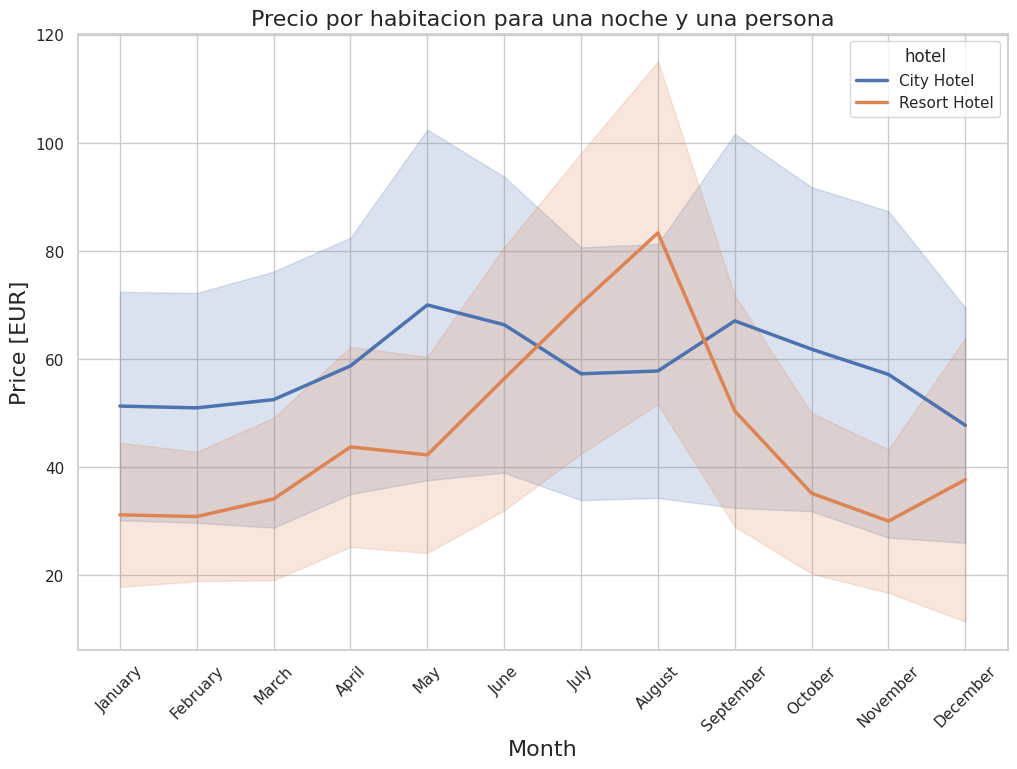

In [8]:
full_data_cln["adr_pp"] = full_data_cln["adr"] / (full_data_cln["adults"] + full_data_cln["children"])
full_data_guests = full_data_cln.loc[full_data_cln["is_canceled"] == 0] # only actual gusts

room_prices_mothly = full_data_guests[["hotel", "arrival_date_month", "adr_pp"]].sort_values("arrival_date_month")

ordered_months = ["January", "February", "March", "April", "May", "June",
          "July", "August", "September", "October", "November", "December"]
room_prices_mothly["arrival_date_month"] = pd.Categorical(room_prices_mothly["arrival_date_month"], categories=ordered_months, ordered=True)

plt.figure(figsize=(12, 8))
sns.lineplot(x = "arrival_date_month", y="adr_pp", hue="hotel", data=room_prices_mothly,
            hue_order = ["City Hotel", "Resort Hotel"], ci="sd", size="hotel", sizes=(2.5, 2.5))
plt.title("Precio por habitacion para una noche y una persona", fontsize=16)
plt.xlabel("Month", fontsize=16)
plt.xticks(rotation=45)
plt.ylabel("Price [EUR]", fontsize=16)
plt.show()

Hemos organizado los datos para que estén listos para su uso en los modelos. Esto implica limpiar todos los datos que están ausentes o vacíos. En las columnas donde existen muchas categorías únicas, hemos utilizado un codificador para reducir la cantidad de posibilidades.

In [9]:
from sklearn.preprocessing import LabelEncoder

df1 = full_data_cln.copy()
df1 = df1.drop(['country','agent','company'],axis=1)
df1 = df1.dropna()

list_1=list(df1.columns)
list_cate=[]
for i in list_1:
    if df1[i].dtype=='object':
        list_cate.append(i)

le=LabelEncoder()
for i in list_cate:
    df1[i]=le.fit_transform(df1[i])
df1.head()

<ipython-input-9-7a82714bfad5>:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,adr_pp
0,1,0,342,2015,5,27,1,0,0,2,0.0,0,0,3,1,0,0,0,2,2,3,0,0,2,0.0,0,0,1,121,0.0
1,1,0,737,2015,5,27,1,0,0,2,0.0,0,0,3,1,0,0,0,2,2,4,0,0,2,0.0,0,0,1,121,0.0
2,1,0,7,2015,5,27,1,0,1,1,0.0,0,0,3,1,0,0,0,0,2,0,0,0,2,75.0,0,0,1,122,75.0
3,1,0,13,2015,5,27,1,0,1,1,0.0,0,0,2,0,0,0,0,0,0,0,0,0,2,75.0,0,0,1,122,75.0
4,1,0,14,2015,5,27,1,0,2,2,0.0,0,0,6,3,0,0,0,0,0,0,0,0,2,98.0,0,1,1,123,49.0


In [10]:
y=df1['hotel']
x=df1.drop('hotel',axis=1)

x_train,x_test,y_train,y_test=train_test_split(x,y,random_state=0,test_size=0.2)


Habiendo completado con éxito la fase de limpieza y preparación de los datos, estamos listos para explorar los modelos de machine learning que nos ayudarán a predecir cancelaciones en un hotel. En esta etapa, utilizaremos técnicas avanzadas para construir un modelo que se ajuste a nuestros datos y nos permita tomar decisiones informadas sobre la gestión de reservas y recursos.

Regresión Logística

Un modelo fundamental en la clasificación de datos binarios es la Regresión Logística. Este enfoque se basa en una función logística para modelar una variable dependiente binaria, como la cancelación de una reserva. La Regresión Logística estima los parámetros de este modelo logístico y es ampliamente utilizado en la predicción de eventos binarios, como "cancelado" o "no cancelado". A través de la Regresión Logística, podemos evaluar la probabilidad de que una reserva se cancele y tomar decisiones basadas en esa probabilidad.

In [11]:
# Crear y entrenar el modelo de regresión logística
reg = LogisticRegression()
reg.fit(x_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred_reg = reg.predict(x_test)
acc_reg = accuracy_score(y_test, y_pred_reg)

# Imprimir el informe de clasificación
print("\n\nClassification Report is:\n", classification_report(y_test, y_pred_reg))

# Imprimir la matriz de confusión
print("\n\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_reg))

# Calcular y mostrar la puntuación de entrenamiento
training_score = reg.score(x_train, y_train) * 100
print("\n\nTraining Score:\n", training_score)

# Imprimir el puntaje de precisión
print(f"\n\nAccuracy Score of Logistic Regression is: {acc_reg}")




/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression





Classification Report is:
               precision    recall  f1-score   support

           0       0.77      0.88      0.82     15926
           1       0.66      0.46      0.54      7916

    accuracy                           0.74     23842
   macro avg       0.71      0.67      0.68     23842
weighted avg       0.73      0.74      0.73     23842



Confusion Matrix:
 [[14064  1862]
 [ 4309  3607]]


Training Score:
 74.02478922863975


Accuracy Score of Logistic Regression is: 0.7411710426977602


El informe de clasificación muestra que el modelo de regresión logística alcanza una precisión general del 74%. No obstante, se evidencia un desempeño desigual en la clasificación de las reservas de hotel, ya sea como canceladas o no canceladas. Para la clase de reservas no canceladas (0), el modelo logra una precisión del 77% y un recall del 88%, lo que indica una efectividad en la identificación de reservas que no se cancelarán. Por otro lado, en la clase de reservas canceladas (1), la precisión es del 66% y el recall del 46%, lo que denota una menor precisión en la predicción de cancelaciones. La puntuación F1 muestra un valor del 82% para las reservas no canceladas y del 54% para las reservas canceladas. Al observar la matriz de confusión, se revela que se cometieron 1,862 falsos positivos y 4,309 falsos negativos. La puntuación de entrenamiento del modelo se sitúa en el 74.02%. En resumen, estos resultados indican que el modelo es más preciso en la predicción de reservas que no se cancelarán, aunque su precisión disminuye en el caso de reservas canceladas.

In [29]:
# Realizar una predicción con un ejemplo de prueba
sample_data = x_test.iloc[0, :]  # Tomamos la primera fila de los datos de prueba
predicted_cancellation = reg.predict([sample_data])

# Texto explicativo de los resultados
if predicted_cancellation[0] == 1:
    print("\nEl modelo predice que la reserva se cancelará.")
else:
    print("\nEl modelo predice que la reserva no se cancelará.")


El modelo predice que la reserva no se cancelará.


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but LogisticRegression was fitted with feature names



hemos realizado una predicción con un ejemplo de prueba, y el modelo predice que la reserva no se cancelará. Esto resalta la importancia de entender y evaluar las métricas del modelo para tomar decisiones informadas sobre la gestión de reservas en el hotel.

In [30]:
x_test.iloc[0, :]

is_canceled                          0.000
lead_time                           21.000
arrival_date_year                 2016.000
arrival_date_month                   6.000
arrival_date_week_number            23.000
arrival_date_day_of_month            4.000
stays_in_weekend_nights              2.000
stays_in_week_nights                 4.000
adults                               2.000
children                             0.000
babies                               0.000
meal                                 2.000
market_segment                       3.000
distribution_channel                 1.000
is_repeated_guest                    0.000
previous_cancellations               0.000
previous_bookings_not_canceled       0.000
reserved_room_type                   0.000
assigned_room_type                   0.000
booking_changes                      0.000
deposit_type                         0.000
days_in_waiting_list                 0.000
customer_type                        2.000
adr        

In [31]:
df1

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,adr_pp
0,1,0,342,2015,5,27,1,0,0,2,0.0,0,0,3,1,0,0,0,2,2,3,0,0,2,0.00,0,0,1,121,0.000000
1,1,0,737,2015,5,27,1,0,0,2,0.0,0,0,3,1,0,0,0,2,2,4,0,0,2,0.00,0,0,1,121,0.000000
2,1,0,7,2015,5,27,1,0,1,1,0.0,0,0,3,1,0,0,0,0,2,0,0,0,2,75.00,0,0,1,122,75.000000
3,1,0,13,2015,5,27,1,0,1,1,0.0,0,0,2,0,0,0,0,0,0,0,0,0,2,75.00,0,0,1,122,75.000000
4,1,0,14,2015,5,27,1,0,2,2,0.0,0,0,6,3,0,0,0,0,0,0,0,0,2,98.00,0,1,1,123,49.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119385,0,0,23,2017,1,35,30,2,5,2,0.0,0,0,5,3,0,0,0,0,0,0,0,0,2,96.14,0,0,1,919,48.070000
119386,0,0,102,2017,1,35,31,2,5,3,0.0,0,0,6,3,0,0,0,4,4,0,0,0,2,225.43,0,2,1,920,75.143333
119387,0,0,34,2017,1,35,31,2,5,2,0.0,0,0,6,3,0,0,0,3,3,0,0,0,2,157.71,0,4,1,920,78.855000
119388,0,0,109,2017,1,35,31,2,5,2,0.0,0,0,6,3,0,0,0,0,0,0,0,0,2,104.40,0,0,1,920,52.200000
